In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_squared_error

import dengue_utils as dutils
import dsutils as du

http://localhost:8888/notebooks/Dropbox/DataScience/dengAI/notebooks_jupyter/Time%20Series/TimeSeries.ipynb

In [2]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [3]:
# Load dataset

features_train = pd.read_csv('../../data/dengue_features_train.csv')
labels_train   = pd.read_csv('../../data/dengue_labels_train.csv')

features_test = pd.read_csv('../../data/dengue_features_test.csv')
print(features_train.shape)
print(features_test.shape)
dengue_dataset = pd.concat([features_train, features_test], axis = 0)

# Join train labes and features
dengue_dataset_labeled = dengue_dataset.merge(labels_train, 
                                              left_on = ['city', 'year', 'weekofyear'], 
                                              right_on = ['city', 'year', 'weekofyear'],
                                              how = 'outer')


features_test.columns

(1456, 24)
(416, 24)


Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [4]:
dengue_dataset.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [5]:
# Get date-cases for one city

#variable = "reanalysis_avg_temp_k"
variable = "total_cases"
dengue_cases_time = dengue_dataset_labeled.loc[dengue_dataset_labeled.city == 'iq', 
                                               ['week_start_date', variable, 'reanalysis_sat_precip_amt_mm', 'weekofyear']]

dengue_cases_time['week_start_date'] = pd.to_datetime(dengue_cases_time['week_start_date'])

#du.show_lineplot(dengue_cases_time, xvalue='week_start_date', yvalue=variable)
dengue_cases_time_train = dengue_cases_time.dropna(subset=[variable])

moving_average(dengue_cases_time_train[variable], 4)

3.5

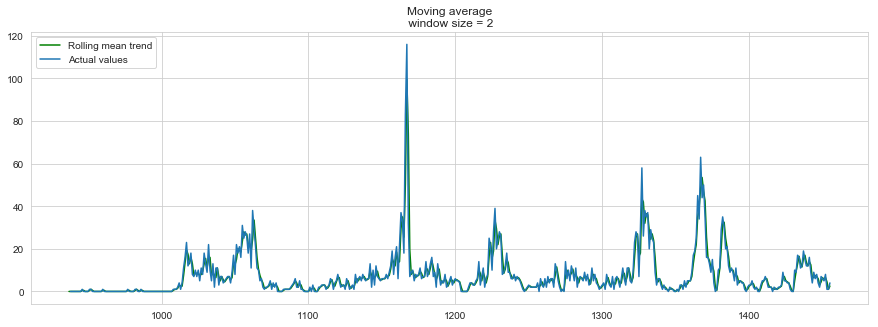

In [6]:
plotMovingAverage(dengue_cases_time_train[variable], 2) 

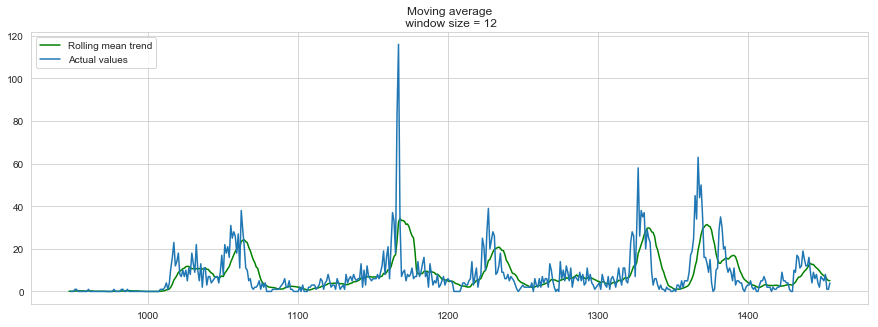

In [7]:
plotMovingAverage(dengue_cases_time_train[variable], 12) 

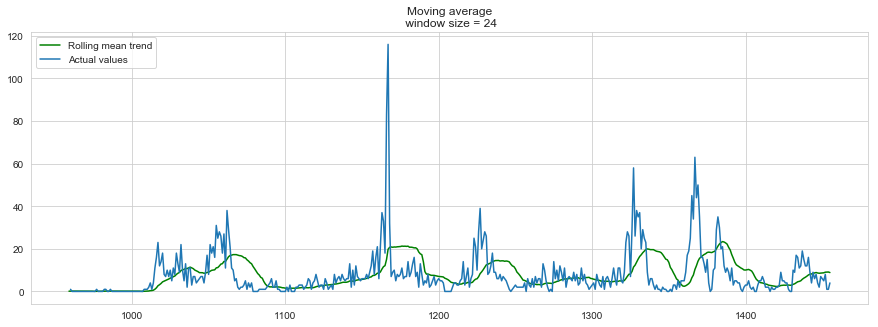

In [8]:
plotMovingAverage(dengue_cases_time_train[variable], 24) 

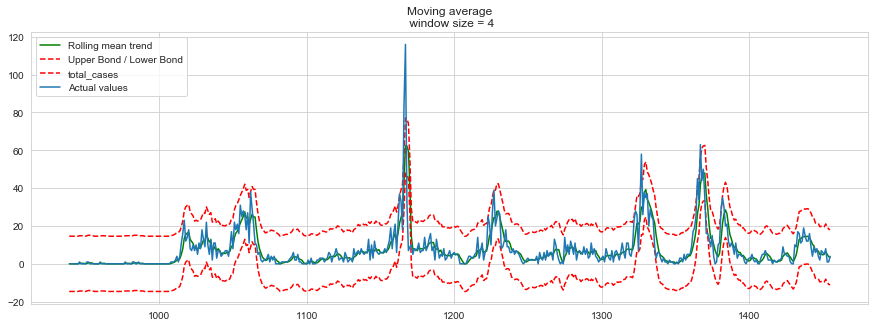

In [9]:
plotMovingAverage(dengue_cases_time_train[variable], 4, plot_intervals=True)

AttributeError: 'Series' object has no attribute 'columns'

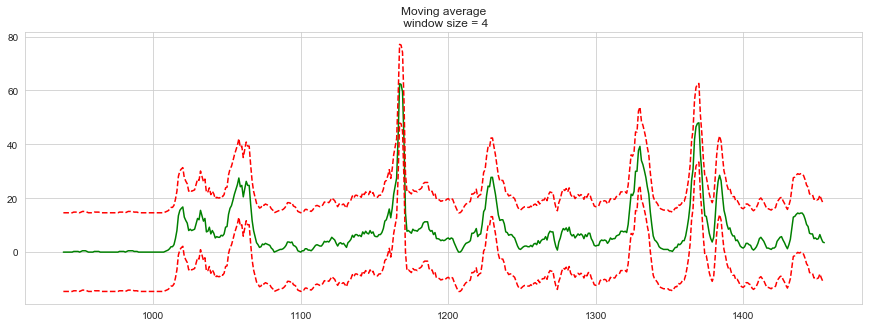

In [10]:
plotMovingAverage(dengue_cases_time_train[variable], 4, plot_intervals=True, plot_anomalies=True)

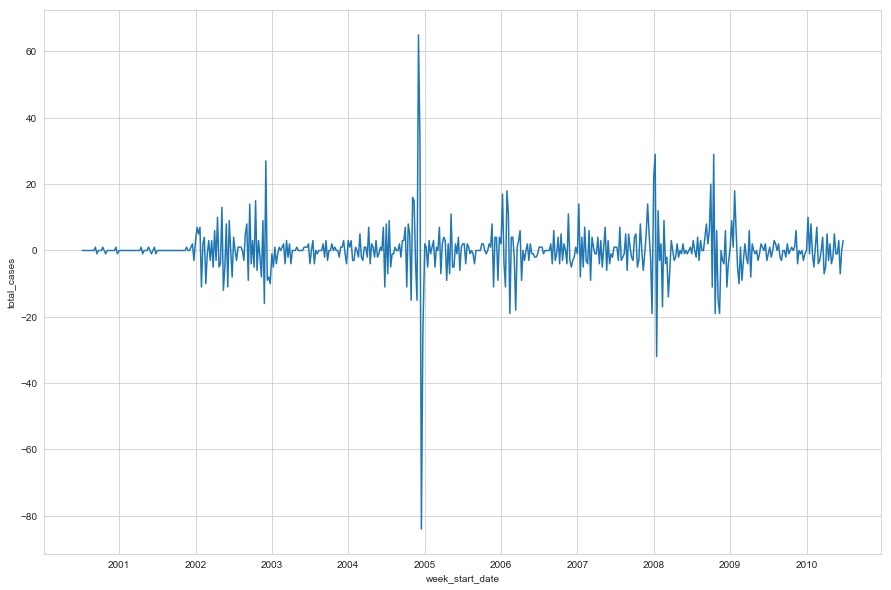

In [8]:
dengue_cases_time[variable] = dengue_cases_time[variable].diff()
du.show_lineplot(dengue_cases_time, xvalue='week_start_date', yvalue=variable)

In [9]:
if dengue_cases_time.index.name == None:
    dengue_cases_time = dengue_cases_time.set_index('week_start_date')


dengue_cases_time_train = dengue_cases_time[dengue_cases_time.index < '2009-01-01']

data_train = dengue_cases_time_train[variable].values

dengue_cases_time_test = dengue_cases_time[dengue_cases_time.index >= '2009-01-01']

data_test = dengue_cases_time_test[variable].values

In [10]:
len(data_train)

442

In [11]:
len(data_train) + len(data_test) - 1

675

Stationarity is important as non-stationary series that depend on time have too many parameters to account for when modelling the time series. diff() method can easily convert a non-stationary series to a stationary series.

ValueError: x and y must have same first dimension, but have shapes (234,) and (0,)

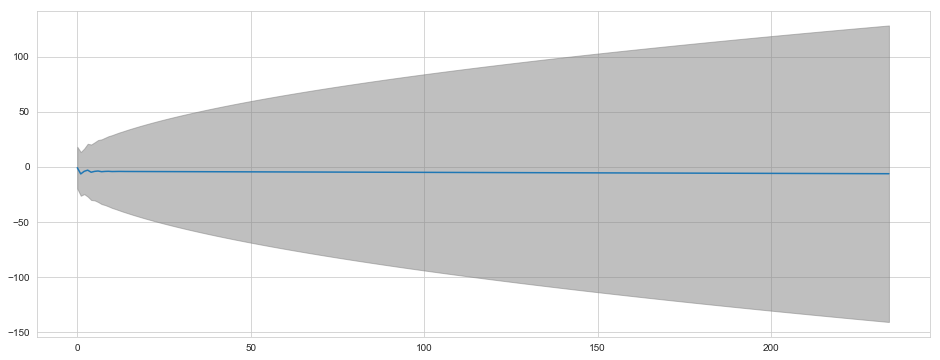

In [12]:
# Predicting the microsoft stocks volume
rcParams['figure.figsize'] = 16, 6
model = ARIMA(dengue_cases_time_train[variable].iloc[1:].values, order=(2,1,0))
result = model.fit()

result.plot_predict(start=442, end=675)
plt.show()
# calculating error
#rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1456].values, predicted_result.values))
#print("The root mean squared error is {}.".format(rmse))